#1  
tk time at knot point k
N number of trajectory (spline) segments
hk = tk+1 − tk duration of spline segment k
xk = x(tk) state at knot point k
uk = u(tk) control at knot point k
wk = w(tk, xk, uk
) integrand of objective function at knot point k
fk = f (tk, xk, uk
) system dynamics at knot point k
 ̇q = d
dt q,  ̈q = d2
dt2 q first and second time-derivatives of q

In [1]:
import osqp
import numpy as np
from scipy import sparse

N = 100
dt = 1 / N
deviation_weight = 0.0
speed_weight = 0.0
accel_weight = dt / 2

# Define problem data

# hessian
x_start_index = 0
v_start_index = x_start_index + N
u_start_index = v_start_index + N
matrix_size = 3 * N - 1
hessian = np.zeros((matrix_size, matrix_size))
for i in range(N):
    hessian[x_start_index + i, x_start_index + i] = deviation_weight * 2
    hessian[v_start_index + i, v_start_index + i] = speed_weight * 2
    if (i != N - 1):
        hessian[u_start_index + i, u_start_index + i] = accel_weight * 2

P = sparse.csc_matrix(hessian)

# constraints
x_start_index = 0
v_start_index = x_start_index + N
u_start_index = v_start_index + N
cons_x_update_start_index = 0
cons_v_update_start_index = cons_x_update_start_index + N - 1
cons_x_start_index = cons_v_update_start_index + N - 1
cons_x_end_index = cons_x_start_index + 1
cons_v_start_index = cons_x_end_index + 1
cons_v_end_index = cons_v_start_index + 1
cons = np.zeros((2 * (N - 1) + 4, 3 * N - 1))
for i in range(N - 1):
    cons[cons_x_update_start_index + i, x_start_index + i + 1] = cons[cons_v_update_start_index + i, v_start_index + i + 1] = 1
    cons[cons_x_update_start_index + i, x_start_index + i] = cons[cons_v_update_start_index +i, v_start_index + i] = -1
    cons[cons_x_update_start_index + i, v_start_index + i + 1] = -dt / 2
    cons[cons_x_update_start_index + i, v_start_index + i] = -dt / 2

    if (i != N - 2):
        cons[cons_v_update_start_index + i, u_start_index + i + 1] = -dt / 2
    cons[cons_v_update_start_index + i, u_start_index + i] = -dt / 2

cons[cons_x_start_index, x_start_index] = cons[cons_v_start_index, v_start_index] = cons[cons_v_end_index, v_start_index + N - 1] = cons[cons_x_end_index, x_start_index + N - 1] = 1

# bounds
lower_bound = np.zeros((2 * (N - 1) + 4, 1))
upper_bound = np.zeros((2 * (N - 1) + 4, 1))
for i in range(N - 1):
    lower_bound[cons_x_update_start_index + i] = upper_bound[cons_x_update_start_index + i] = 0
    lower_bound[cons_v_update_start_index + i] = upper_bound[cons_v_update_start_index + i] = 0

lower_bound[cons_x_start_index] = upper_bound[cons_x_start_index] = 0
lower_bound[cons_x_end_index] = upper_bound[cons_x_end_index] = 1
lower_bound[cons_v_start_index] = upper_bound[cons_v_start_index] = 0
lower_bound[cons_v_end_index] = upper_bound[cons_v_end_index] = 0

A = sparse.csc_matrix(cons)
l = lower_bound
u = upper_bound

# Create an OSQP object
prob = osqp.OSQP()

# Setup workspace and change alpha parameter
prob.setup(P=P, A=A, l=l, u=u)

# Solve problem
res = prob.solve()

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 29, constraints m = 22
          nnz(P) + nnz(A) = 84
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.00e+00   1.00e+02   1.00e-01   7.64e-05s
  25   1.0898e+01   2.83e-04   4.74e-04   1.00e-01   1.14e-04s

status:               solved
number of iteratio

In [2]:
# analytic solution
def f(t):
    return 3 * t * t - 2 * t * t * t

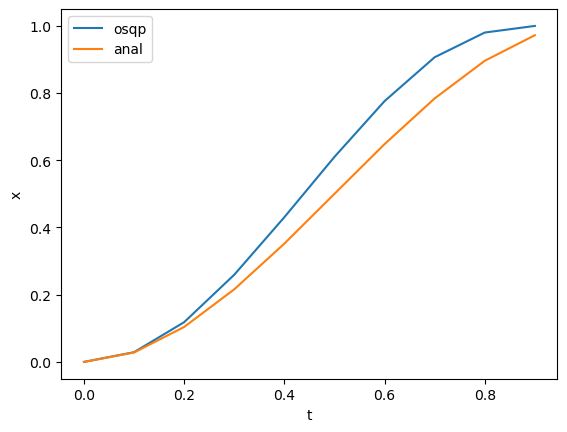

In [3]:
import matplotlib.pyplot as plt

t = np.arange(0, 1, dt)
x = res.x[:N]
anal_x = [f(i) for i in t]
plt.plot(t, x, label="osqp")
plt.plot(t, anal_x, label="anal")
plt.legend(loc="upper left")
plt.xlabel('t')
plt.ylabel('x')
plt.show()